<a href="https://colab.research.google.com/github/hadinursalim/Bioinformatics/blob/main/grape_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **grape-disease-classification**

# **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/workspace/grape-disease-classification

Mounted at /content/drive/
/content/drive/MyDrive/workspace/grape-disease-classification


# **Check NVIDIA GPU Info**

In [ ]:
!nvidia-smi

Sun Aug 14 13:42:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3065238032911122197
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13756124997110670585
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# **Import Packages**

In [ ]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import cv2
import glob
import time
import math
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set random seed for consistency
random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

# Displays all outputs of a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 5]

print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

TensorFlow version: 2.8.2
Keras version: 2.8.0


# **Define Directory Paths**

Dataset kita harus diatur dengan cara tertentu sehingga kita dapat memanfaatkan ImageDataGenerator Keras Pohon direktori untuk dataset kita harus mengikuti format yang sama seperti gambar di bawah ini.

![](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

Sumber: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [ ]:
work_dir = '.'
data_dir = os.path.join(work_dir, 'data')
data_arr_dir = os.path.join(work_dir, 'data_arr')
model_dir = os.path.join(work_dir, 'saved_models')

# Original data (before split)
black_measles_dir = os.path.join(data_dir, 'black_measles')
black_rot_dir = os.path.join(data_dir, 'black_rot')
leaf_blight_dir = os.path.join(data_dir, 'leaf_blight')
healthy_dir = os.path.join(data_dir, 'healthy')

# Train/Validation/Test
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Training data by class
train_black_measles_dir = os.path.join(train_dir, 'black_measles')
train_black_rot_dir = os.path.join(train_dir, 'black_rot')
train_leaf_blight_dir = os.path.join(train_dir, 'leaf_blight')
train_healthy_dir = os.path.join(train_dir, 'healthy')

# Validation data by class
validation_black_measles_dir = os.path.join(validation_dir, 'black_measles')
validation_black_rot_dir = os.path.join(validation_dir, 'black_rot')
validation_leaf_blight_dir = os.path.join(validation_dir, 'leaf_blight')
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# Test data by class
test_black_measles_dir = os.path.join(test_dir, 'black_measles')
test_black_rot_dir = os.path.join(test_dir, 'black_rot')
test_leaf_blight_dir = os.path.join(test_dir, 'leaf_blight')
test_healthy_dir = os.path.join(test_dir, 'healthy')

In [ ]:

os.mkdir(model_dir)

os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

os.mkdir(train_black_measles_dir)
os.mkdir(train_black_rot_dir)
os.mkdir(train_leaf_blight_dir)
os.mkdir(train_healthy_dir)

os.mkdir(validation_black_measles_dir)
os.mkdir(validation_black_rot_dir)
os.mkdir(validation_leaf_blight_dir)
os.mkdir(validation_healthy_dir)

os.mkdir(test_black_measles_dir)
os.mkdir(test_black_rot_dir)
os.mkdir(test_leaf_blight_dir)
os.mkdir(test_healthy_dir)

# **Construct Dataset**

**Observe Number of Images Per Class**

In [ ]:
num_black_measles = len(os.listdir(black_measles_dir))
num_black_rot = len(os.listdir(black_rot_dir))
num_leaf_blight = len(os.listdir(leaf_blight_dir))
num_healthy = len(os.listdir(healthy_dir))
total_images = num_black_measles + num_black_rot + num_leaf_blight + num_healthy
                                   
print('Total Images: {}'.format(total_images))
print('black_measles class has {} images'.format(num_black_measles))
print('black_rot class has {} images'.format(num_black_rot))
print('leaf_blight class has {} images'.format(num_leaf_blight))
print('healthy class has {} images'.format(num_healthy))

Total Images: 4062
black_measles class has 1383 images
black_rot class has 1180 images
leaf_blight class has 1076 images
healthy class has 423 images


In [ ]:
pct_black_measles = (num_black_measles / total_images) * 100.0
pct_black_rot = (num_black_rot / total_images) * 100.0
pct_leaf_blight = (num_leaf_blight / total_images) * 100.0
pct_healthy = (num_healthy / total_images) * 100.0

print('Percentage of black_measles class: {:.2f}%'.format(pct_black_measles))
print('Percentage of black_rot class: {:.2f}%'.format(pct_black_rot))
print('Percentage of leaf_blight class: {:.2f}%'.format(pct_leaf_blight))
print('Percentage of healthy class: {:.2f}%'.format(pct_healthy))

Percentage of black_measles class: 34.05%
Percentage of black_rot class: 29.05%
Percentage of leaf_blight class: 26.49%
Percentage of healthy class: 10.41%


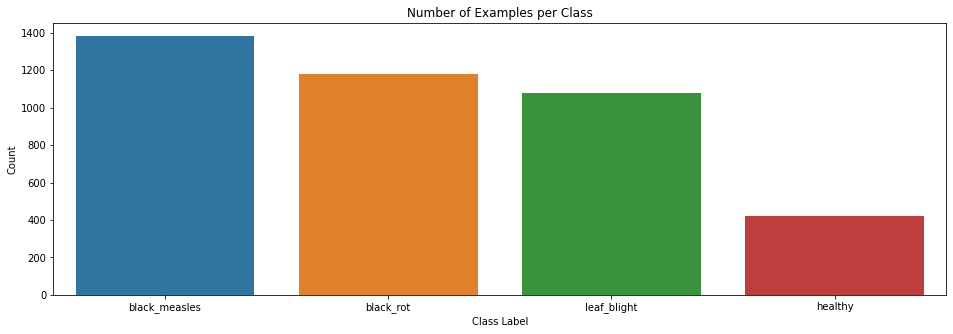

In [ ]:
data_dist = pd.DataFrame.from_dict(data={ 'black_measles': [num_black_measles],
                                          'black_rot': [num_black_rot],
                                          'leaf_blight': [num_leaf_blight],
                                          'healthy': [num_healthy] } )
sns.barplot(data=data_dist);
plt.xlabel('Class Label');
plt.ylabel('Count');
plt.title('Number of Examples per Class');

Terlihat bahwa dataset yang dimiliki cukup tidak seimbang (seperti dalam kasus kelas sehat). Namun, kami akan mempertimbangkan ini nanti dalam analisis kami.

**Shuffle and Train-Validation-Test Split**

Kami tidak akan membagi dataset kami menjadi train, validasi, dan test set. Pertama kita akan mengacak gambar dan menerapkan pemisahan bertingkat untuk mempertimbangkan distribusi kumpulan data.

Kami akan mengalokasikan 80% untuk pelatihan dan 20% untuk tes. Kemudian kita akan membagi training set menjadi 80% training dan 20% validasi.

In [ ]:
def split_data(data_src, label, test_size=0.2, val_size=0.2):
  '''
  Function to split the original dataset into training, validation, and test
  sets and copies to the respective folders. 
  @param data_src - the path to the data
  @param label - the class label
  @test_size - the percent allocated for test 
  @val_size - the percent allocated for validation (of the training data)
  '''
  assert label in ['black_measles', 'black_rot', 'leaf_blight', 'healthy'], \
    "Make sure class label is correct"
  
  train_dir = os.path.join(data_src, 'train', label)
  val_dir = os.path.join(data_src, 'validation', label)
  test_dir = os.path.join(data_src, 'test', label)
  
  assert len(os.listdir(train_dir)) == 0, "Training directory is not empty."
  assert len(os.listdir(val_dir)) == 0, "Validation directory is not empty."
  assert len(os.listdir(test_dir)) == 0, "Test directory is not empty."
  
  data_path = os.path.join(data_src, label)
  num_examples = len(os.listdir(data_path))
  
  # Shuffle the data
  datafiles = os.listdir(data_path)
  random.shuffle(datafiles)
  
  # Train-test split
  num_test = math.floor(num_examples*0.2)
  num_train = num_examples - num_test
  
  # Train-validation split
  num_val = math.floor(num_train*0.2)
  num_train = num_train - num_val
  
  # Train, validation, and test data
  train_files = datafiles[:num_train]
  val_files = datafiles[num_train:num_train+num_val]
  test_files = datafiles[num_train+num_val:]
    
  # Copy training data
  for filename in train_files:
    src = os.path.join(data_src, label, filename)
    dst = os.path.join(train_dir, filename)
    shutil.copyfile(src, dst)
    
  # Copy validation data
  for filename in val_files:
    src = os.path.join(data_src, label, filename)
    dst = os.path.join(val_dir, filename)
    shutil.copyfile(src, dst)
    
  # Copy test data
  for filename in test_files:
    src = os.path.join(data_src, label,filename)
    dst = os.path.join(test_dir, filename)
    shutil.copyfile(src, dst)

Dengan menggunakan fungsi di atas, kita dapat mengambil dataset gambar dari setiap kategori label dan membaginya menjadi set pelatihan, validasi, dan pengujian dengan pembagian 80-20. Menjalankan kode di bawah ini akan mempartisi dataset secara bertingkat dan menyalin gambar ke folder masing-masing.

**CATATAN: Fungsi di bawah ini mungkin memerlukan beberapa saat.**

In [ ]:
for label in ['black_measles', 'black_rot', 'leaf_blight', 'healthy']:
  split_data(data_dir, label)

In [ ]:
# Sanity check 
num_train_black_measles = len(os.listdir(train_black_measles_dir))
num_train_black_rot = len(os.listdir(train_black_rot_dir))
num_train_leaf_blight = len(os.listdir(train_leaf_blight_dir))
num_train_healthy = len(os.listdir(train_healthy_dir))

num_val_black_measles = len(os.listdir(validation_black_measles_dir))
num_val_black_rot = len(os.listdir(validation_black_rot_dir))
num_val_leaf_blight = len(os.listdir(validation_leaf_blight_dir))
num_val_healthy = len(os.listdir(validation_healthy_dir))

num_test_black_measles = len(os.listdir(test_black_measles_dir))
num_test_black_rot = len(os.listdir(test_black_rot_dir))
num_test_leaf_blight = len(os.listdir(test_leaf_blight_dir))
num_test_healthy = len(os.listdir(test_healthy_dir))

total_train = num_train_black_measles + num_train_black_rot + \
                num_train_leaf_blight + num_train_healthy
total_val = num_val_black_measles + num_val_black_rot + \
              num_val_leaf_blight + num_val_healthy
total_test = num_test_black_measles + num_test_black_rot + \
              num_test_leaf_blight + num_test_healthy

def check_distribution(total, black_measles, black_rot, leaf_blight, healthy):
  print('% of black_measles: {:.2f}%'.format((black_measles/total)*100.0))
  print('% of blacK_rot: {:.2f}%'.format((black_rot / total)*100))
  print('% of leaf_blight: {:.2f}%'.format((leaf_blight / total)*100.0))
  print('% of healthy: {:.2f}%'.format((healthy / total)*100.0))
  print()
  
print('Total images:', total_train + total_val + total_test)
print('Total black_measles:', num_train_black_measles+num_val_black_measles+num_test_black_measles)
print('Total blacK_rot:', num_train_black_rot+num_val_black_rot+num_test_black_rot)
print('Total leaf_blight:', num_train_leaf_blight+num_val_leaf_blight+num_test_leaf_blight)
print('Total healthy:', num_train_healthy+num_val_healthy+num_test_healthy)
print()
print('Number of black_measles training images:', num_train_black_measles)
print('Number of black_rot training images:', num_train_black_rot)
print('Number of leaf_blight training images:', num_train_leaf_blight)
print('Number of healthy training images:', num_train_healthy)
print()
print('Number of black_measles validation images:', num_val_black_measles)
print('Number of black_rot validation images:', num_val_black_rot)
print('Number of leaf_blight validation images:', num_val_leaf_blight)
print('Number of healthy validation images:', num_val_healthy)
print()
print('Number of black_measles test images:', num_test_black_measles)
print('Number of black_rot test images:', num_test_black_rot)
print('Number of leaf_blight test images:', num_test_leaf_blight)
print('Number of healthy test images:', num_test_healthy)
print()
print('Training distribution')
check_distribution(total_train, num_train_black_measles, num_train_black_rot,
                    num_train_leaf_blight, num_train_healthy)
print('Validation distribution')
check_distribution(total_val, num_val_black_measles, num_val_black_rot,
                    num_val_leaf_blight, num_val_healthy)
print('Test distribution')
check_distribution(total_test, num_test_black_measles, num_test_black_rot,
                    num_test_leaf_blight, num_test_healthy)

Total images: 4062
Total black_measles: 1383
Total blacK_rot: 1180
Total leaf_blight: 1076
Total healthy: 423

Number of black_measles training images: 886
Number of black_rot training images: 756
Number of leaf_blight training images: 689
Number of healthy training images: 272

Number of black_measles validation images: 221
Number of black_rot validation images: 188
Number of leaf_blight validation images: 172
Number of healthy validation images: 67

Number of black_measles test images: 276
Number of black_rot test images: 236
Number of leaf_blight test images: 215
Number of healthy test images: 84

Training distribution
% of black_measles: 34.04%
% of blacK_rot: 29.04%
% of leaf_blight: 26.47%
% of healthy: 10.45%

Validation distribution
% of black_measles: 34.10%
% of blacK_rot: 29.01%
% of leaf_blight: 26.54%
% of healthy: 10.34%

Test distribution
% of black_measles: 34.03%
% of blacK_rot: 29.10%
% of leaf_blight: 26.51%
% of healthy: 10.36%



Kami melihat bahwa kereta bertingkat, validasi, dan pemisahan pengujian kami menghasilkan distribusi yang relatif konsisten seperti kumpulan data asli kami. Ini bagus karena partisi data kami mewakili distribusi data asli. Namun, kami masih memiliki masalah ketidakseimbangan kelas.

# **Exploratory Data Analysis**

Setelah kumpulan data dibuat dan dibagi dengan benar menjadi kumpulan pelatihan, validasi, dan pengujian, kita dapat menjalankan beberapa analisis data eksplorasi untuk mengekstrak wawasan.

**Observe Example Images**

In [ ]:
def read_img(filepath, size):
  """
  Helper function to convert an image into a Numpy array.
  @param filepath - path to the image
  @param size - size to resize the image to
  """
  img = image.load_img(filepath, target_size=size)
  img = image.img_to_array(img)
  return img

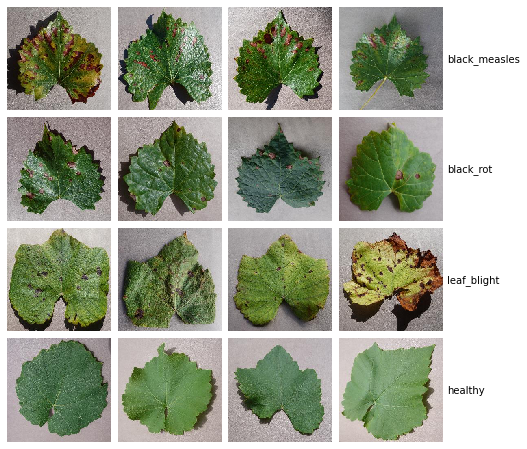

In [ ]:
CATEGORIES = ['black_measles', 'black_rot', 'leaf_blight', 'healthy']
NUM_CATEGORIES = len(CATEGORIES)
height, width = 256, 256

# Create image grid
fig = plt.figure(num=1, figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES,NUM_CATEGORIES),
                 axes_pad=0.1) # pad between axes in inch.

# Plot each example image per grid square
i = 0
for category in CATEGORIES:
  for j in range(4):
    ax = grid[i]
    path = os.path.join(data_dir, category)
    file = category + str(j) + '.jpg'
    img = read_img(os.path.join(path, file), size=(height, width))
    ax.imshow(img/255., interpolation='nearest', aspect='auto')
    ax.axis('off')
    if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
      ax.text(x=height*1.05, y=height//2, s=category, verticalalignment='center')
    i += 1

fig.show();

Kita dapat melihat beberapa perbedaan antara kelas (titik hitam melingkar untuk busuk hitam, bintik-bintik coklat non-globular untuk campak hitam, dll.). Namun, sebagian besar gambar mungkin tampak sangat mirip dan penting untuk mengamati apakah ada perbedaan yang jelas antara kelas.

# **Load Images as Numpy Arrays (OpenCV vs. Keras vs. Pillow)**

Langkah ini adalah memuat semua gambar ke dalam tensor array Numpy untuk diproses lebih lanjut. Namun, perlu dicatat bahwa OpenCV menghasilkan orientasi yang berbeda untuk array ini daripada Keras dan Pillow. Hal ini dapat diamati di bawah ini.

Membandingkan OpenCV dan Bantal: https://www.kaggle.com/vfdev5/pil-vs-opencv

OpenCv dan Pillow menampilkan gambar yang berbeda: https://stackoverflow.com/questions/49965000/images-opened-in-pillow-and-opencv-are-not-equivelant

https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format

Beberapa catatan:

* OpenCV berbeda dari Keras dan Bantal (karena format BGR bukan RGB)
* Keras dan Bantal sama
* Keras menggunakan tf.keras.preprocessing.image.img_to_array(image_keras) untuk berubah menjadi array Numpy
* Bantal menggunakan np.array(image) untuk berubah menjadi array Numpy
* Keras harus dicast ke tipe data uint8 (seperti OpenCV dan Pillow) atau dinormalisasi dengan 255 sebelum menggunakan plt.imshow()

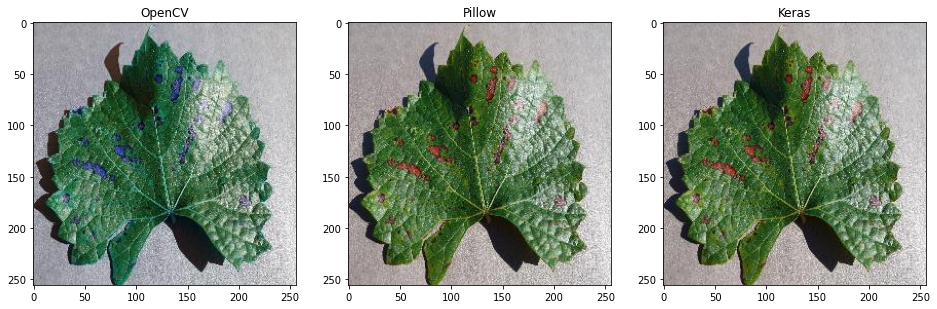

In [ ]:
# OpenCV 
image_opencv = cv2.imread(os.path.join(black_measles_dir, 'black_measles1.jpg'))

# Pillow
image_pillow = Image.open(os.path.join(black_measles_dir, 'black_measles1.jpg'))
image_pillow = np.array(image_pillow)

# Keras
image_keras = tf.keras.preprocessing.image.load_img(
                os.path.join(black_measles_dir, 'black_measles1.jpg'))
image_keras = tf.keras.preprocessing.image.img_to_array(image_keras)

pylab.subplot(1, 3, 1);
pylab.title('OpenCV')
plt.imshow(image_opencv);

pylab.subplot(1, 3, 2);
pylab.title('Pillow')
plt.imshow(image_pillow);  # Pillow doesn't need to be normalized

pylab.subplot(1, 3, 3);
pylab.title('Keras')
plt.imshow(image_keras.astype('uint8'));  # Keras needs uint8 or normalized

In [ ]:
print('Keras == Pillow:', np.array_equal(image_keras, image_pillow))
print('Keras == OpenCV:', np.array_equal(image_keras, image_opencv))
print('Pillow == OpenCV:', np.array_equal(image_pillow, image_opencv))

Keras == Pillow: True
Keras == OpenCV: False
Pillow == OpenCV: False


Kita dapat melihat bahwa Keras dan Pillow menghasilkan array Numpy gambar yang benar dan OpenCV tidak.

Masalahnya adalah bahwa OpenCV memiliki orientasi yang berbeda untuk saluran warna (BGR) dari Keras/Bantal (RGB). Kami hanya dapat memperbaikinya dengan membalikkan orientasi saluran warna menggunakan:

open_cv_image[:, :, ::-1]

atau

cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB)

In [ ]:
print('Color channels for OpenCV:', image_opencv[0,0,:])
print('Color channels for Keras:', image_keras[0,0,:])
print('Color channels for Pillow:', image_pillow[0,0,:])

Color channels for OpenCV: [142 142 148]
Color channels for Keras: [148. 142. 142.]
Color channels for Pillow: [148 142 142]


Color channels for OpenCV: [148 142 142]


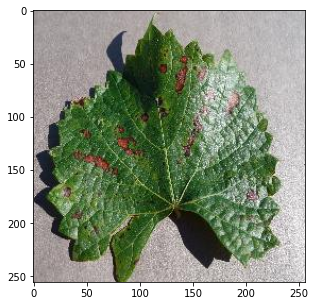

In [ ]:
image_opencv_fixed = cv2.cvtColor(image_opencv, cv2.COLOR_BGR2RGB)
print('Color channels for OpenCV:', image_opencv_fixed[0,0,:])
plt.imshow(image_opencv_fixed);

In [ ]:
# Black measles Numpy array
black_measles_arr = [read_img(os.path.join(train_black_measles_dir, img), \
                    (256, 256)) for img in os.listdir(train_black_measles_dir)]

# Black rot Numpy array
black_rot_arr = [read_img(os.path.join(train_black_rot_dir, img), \
                 (256, 256)) for img in os.listdir(train_black_rot_dir)]

# Leaf blight Numpy array
leaf_blight_arr = [read_img(os.path.join(train_leaf_blight_dir, img), \
                   (256, 256)) for img in os.listdir(train_leaf_blight_dir)]

# Healthy Numpy array
healthy_arr = [read_img(os.path.join(train_healthy_dir, img),\
               (256, 256)) for img in os.listdir(train_healthy_dir)]

# Save Numpy arrays of images
np.save(os.path.join(data_arr_dir, 'black_measles.npy'), arr=black_measles_arr)
np.save(os.path.join(data_arr_dir, 'black_rot.npy'), arr=black_rot_arr)
np.save(os.path.join(data_arr_dir, 'leaf_blight.npy'), arr=leaf_blight_arr)
np.save(os.path.join(data_arr_dir, 'healthy.npy'), arr=healthy_arr)

In [ ]:
# Load Numpy arrays of images
black_measles_arr = np.load(os.path.join(data_arr_dir, 'black_measles.npy'))
black_rot_arr = np.load(os.path.join(data_arr_dir, 'black_rot.npy'))
leaf_blight_arr = np.load(os.path.join(data_arr_dir, 'leaf_blight.npy'))
healthy_arr = np.load(os.path.join(data_arr_dir, 'healthy.npy'))

In [ ]:
# Reshape arrays
black_measles_arr = black_measles_arr.reshape(886, 256*256*3)
black_rot_arr = black_rot_arr.reshape(756, 256*256*3)
leaf_blight_arr = leaf_blight_arr.reshape(689, 256*256*3)
healthy_arr = healthy_arr.reshape(272, 256*256*3)

# **t-Distributed Stochatic Neighbor Embedding (t-SNE)**

situs web t-SNE: https://lvdmaaten.github.io/tsne/
sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

t-SNE adalah teknik pengurangan dimensi yang sangat cocok untuk visualisasi dataset dimensi tinggi. Ia bekerja dengan mengubah kesamaan antara titik data untuk menggabungkan probabilitas dan mencoba meminimalkan perbedaan KL antara probabilitas gabungan dari embedding dimensi rendah dan data dimensi tinggi. t-SNE juga bersifat stokastik, artinya dapat menghasilkan hasil yang berbeda pada inisialisasi yang berbeda (fungsi biaya non-cembung).

Karena dimensi gambar masukan kami adalah (256, 256, 3) = 256*256*3 = 196.608 dimensi, t-SNE adalah pilihan yang baik untuk mencoba memvisualisasikan apakah ada perbedaan yang jelas antara kelas. Direkomendasikan untuk terlebih dahulu menjalankan metode pengurangan dimensi yang berbeda (misalnya PCA untuk data padat atau TruncatedSVD untuk data jarang) untuk mengurangi jumlah dimensi ke jumlah yang wajar (misalnya, 50) jika jumlah fitur sangat tinggi. Tujuannya adalah untuk menekan beberapa kebisingan dan mempercepat perhitungan jarak berpasangan antara sampel.

In [ ]:
def pca(X=np.array([]), no_dims=50):
  """
  Runs PCA on an array X to reduce its dimensoinality to 
  no_dims dimensions.
  @param X - the data matrix to reduce dimensionality
  @param no_dims - the number of dimensions to reduce dimensionality to
  """
  print('Running PCA on the data...')
  mean_vec = np.mean(a=X, axis=0)
  X_cov = (X-mean_vec).T.dot(X-mean_vec) / (X.shape[0]-1)
  eig_vals, eig_vecs = np.linalg.eig(X_cov.T)
  idx = np.argsort(np.abs(eig_vals))[::-1]
  eig_vecs = eig_vecs[:, idx]
  Y = np.dot(X, eig_vecs[:, 0:no_dims])
  return Y

def plot_scatter(x, labels):
  """
  Function to create a scatter plot for visualization of data
  along with respective colors/labels.
  @param X - 2D Numpy array of data reduced to 2-dimensions using t-SNE or PCA
  @param labels - 1D Numpy array of class label strings
  """
  num_classes = len(np.unique(labels))
  color_palette = np.array(sns.color_palette('hls', num_classes))
  f = plt.figure(figsize=(10,10))
  ax = plt.subplot(aspect='equal')
  for i, label in enumerate(np.unique(labels)):
    idx = np.where(labels == label)
    ax.scatter(x[idx,0], x[idx,1], s=30, alpha=0.6, 
                    c=[color_palette[i]], label=label)
  ax.legend(loc='best', fontsize='medium')
  ax.axis('off')
  ax.axis('tight')
  plt.title('Visualization of Classes in 2D')

In [ ]:
# Create the 1D array of class labels
black_measles_lab = np.full(black_measles_arr.shape[0], 'black_measles')
black_rot_lab = np.full(black_rot_arr.shape[0], 'black_rot')
leaf_blight_lab = np.full(leaf_blight_arr.shape[0], 'leaf_blight')
healthy_lab = np.full(healthy_arr.shape[0], 'healthy')

labels = (black_measles_lab, black_rot_lab, leaf_blight_lab, healthy_lab)
labels = np.hstack(labels) 

In [ ]:
labels.shape

(2603,)

In [ ]:
# Create a stacked array of the training instances 
data_tuple = (black_measles_arr, black_rot_arr, leaf_blight_arr, healthy_arr)
data = np.vstack(tup=data_tuple)/255. # normalize 

In [ ]:
data.shape

(2603, 196608)

In [ ]:
# Run PCA on data
start = time.time()
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data)
end = time.time()

print('Took {:.2f} seconds.'.format(end-start))

Took 30.43 seconds.


In [ ]:
data_pca.shape

(2603, 50)

In [ ]:
# Run t-SNE on data
start = time.time()
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data_pca)
end = time.time()

print('Took {:.2f} seconds'.format(end-start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Took 23.62 seconds


In [ ]:
data_tsne.shape

(2603, 2)

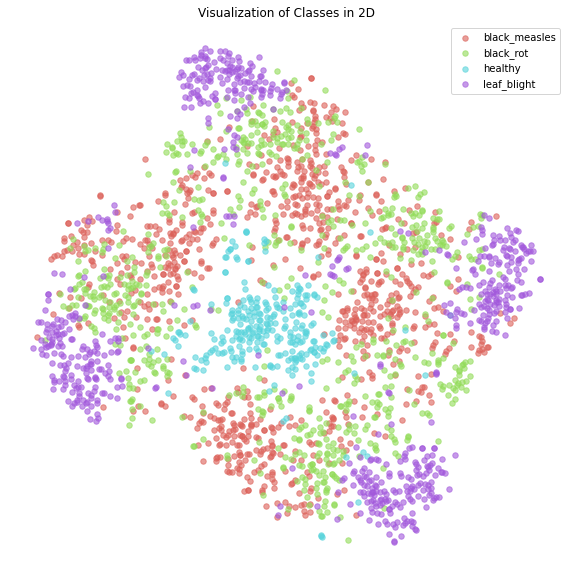

In [ ]:
# Visualize the 2D class scatter plot
plot_scatter(data_tsne, labels);

Mengamati plot pencar visualisasi 2D t-SNE kita melihat bahwa kelas memiliki beberapa sifat yang membedakan. Lebih khusus lagi, daun yang sehat lebih banyak bergerombol di tengah, terlepas dari banyak daun lainnya. Namun, kita juga melihat bahwa kelas penyakit (yaitu, campak hitam, busuk hitam, dan hawar daun) dikelompokkan di empat sudut terpisah dari plot pencar. Meskipun ada pengelompokan yang layak di setiap sudut untuk setiap kelas penyakit, kita akan melihat apakah kita dapat mengklasifikasikan gambar dengan benar menggunakan arsitektur CNN yang berbeda. Secara keseluruhan, visualisasi dikelompokkan dengan cukup baik, terutama mengingat fakta bahwa kami memvisualisasikan representasi 2D dari data kami yang awalnya berasal dari 196.608 dimensi fitur vektor.

# **Training an Image Classifier**

**Helper Functions**

In [ ]:
def smooth_curve(points, factor=0.8):
  """
  Helper function to help smooth accuracy/loss plots using an exponential
  moving average of the loss and accuracy values. 
  """
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

def get_plots(history, smooth=False):
  """
  Helper function to plot training/validation accuracy/loss.
  @param history - Keras model history 
  @param smooth - Boolean for whether to smooth plots or not
  """
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  
  if smooth == True:
    acc = smooth_curve(acc)
    val_acc = smooth_curve(val_acc)
    loss = smooth_curve(loss)
    val_loss = smooth_curve(val_loss)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc,'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def get_metrics(model, generator, steps, target_names=[]):
  """
  Function to print out confusion matrix and classification report.
  """
  target_names = ['black_measles', 'black_rot', 'leaf_blight', 'healthy']
  abbreviations = ['BM', 'BR', 'LB', 'H']
  
  # Get predictions for data
  y_pred = model.predict_generator(generator=generator, steps=steps)
  y_pred = np.argmax(a=y_pred, axis=1)
  
  # Get confusion matix
  cnf_mat = confusion_matrix(y_true=generator.classes, y_pred=y_pred)
  fig, ax = plt.subplots(1)
  ax = sns.heatmap(cnf_mat, ax=ax, cmap=plt.cm.Blues, annot=True, fmt='g')
  ax.set_xticklabels(abbreviations)
  ax.set_yticklabels(abbreviations)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.show()
  
  # Get classification report
  print('Classification Report')
  print(classification_report(y_true=generator.classes, y_pred=y_pred, 
                              target_names=target_names))

**Parameters**

In [ ]:
img_height, img_width = 256, 256
batch_size = 20
epochs = 30

print('Total number of training examples:', total_train)
print('Total number of validation examples:', total_val)
print('Total number of test examples:', total_test)

Total number of training examples: 2603
Total number of validation examples: 648
Total number of test examples: 811


**Training from Scratch**

Kami pertama-tama akan mencoba dan melatih model dari awal dan mengamati ini sebagai patokan.

In [ ]:
model = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', \
                  input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ImageDataGenerator Tutorial: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(img_height, img_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=42)

validation_generator = test_datagen.flow_from_directory(
                          validation_dir,
                          target_size=(img_height, img_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

Found 2603 images belonging to 4 classes.
Found 648 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=total_val // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
130/130 [==============================] - 38s 193ms/step - loss: 0.9648 - acc: 0.5761 - val_loss: 0.7521 - val_acc: 0.7266
Epoch 2/30
130/130 [==============================] - 14s 105ms/step - loss: 0.3575 - acc: 0.8750 - val_loss: 0.2940 - val_acc: 0.8922
Epoch 3/30
130/130 [==============================] - 13s 99ms/step - loss: 0.1718 - acc: 0.9319 - val_loss: 0.1229 - val_acc: 0.9578
Epoch 4/30
130/130 [==============================] - 13s 98ms/step - loss: 0.1296 - acc: 0.9520 - val_loss: 0.2036 - val_acc: 0.9203
Epoch 5/30
130/130 [==============================] - 13s 100ms/step - loss: 0.0656 - acc: 0.9768 - val_loss: 0.1029 - val_acc: 0.9625
Epoch 6/30
130/130 [==============================] - 13s 98ms/step - loss: 0.0669 - acc: 0.9783 - val_loss: 0.1117 - val_acc: 0.9672
Epoch 7/30
130/130 [==============================] - 14s 103ms/step - loss: 0.0408 - acc: 0.9830 - val_loss: 0.0691 - val_acc: 0.9781
Epoch 8/30
130/130 [==============================] - 13s 

In [ ]:
model.save(os.path.join(model_dir, 'disease-scratch.h5'))

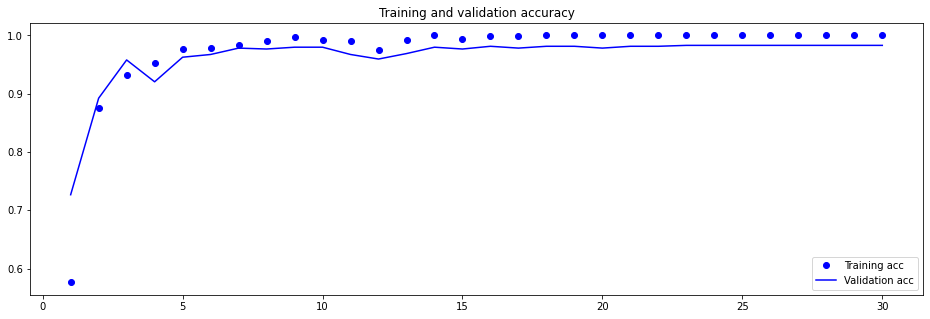

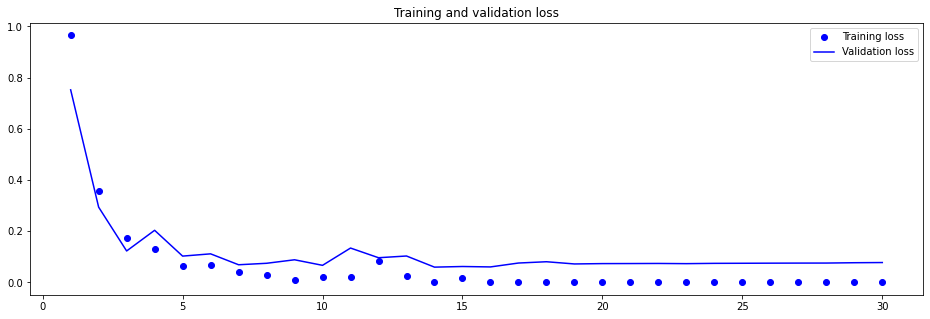

In [ ]:
get_plots(history)

Kami melihat bahwa pelatihan dari awal memberikan hasil yang cukup tinggi dalam hal akurasi. Namun, karena kita berurusan dengan kumpulan data yang tidak seimbang, akurasi mungkin bukan metrik yang bagus untuk digunakan. Dalam hal ini, kami akan memplot matriks konfusi dan mengamati presisi, akurasi, dan skor F1 dari pengklasifikasi kami.

Untuk kasus ini, kita perlu membangun generator data lain untuk evaluasi validasi data. Penting untuk mengatur shuffle ke False sehingga data dapat dibandingkan dengan benar dengan probabilitas kelas oleh predict_generator dalam urutan yang benar.

In [ ]:
# Create the new validation generator for test/evaluation
val_test_gen = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 648 images belonging to 4 classes.


In [ ]:
# Observe the classes
val_test_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

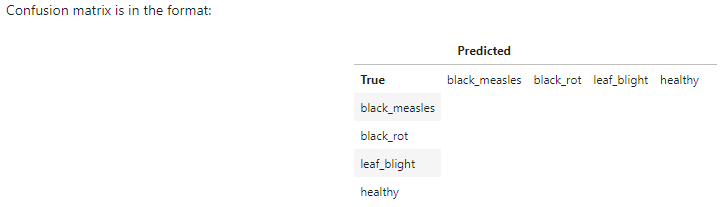

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


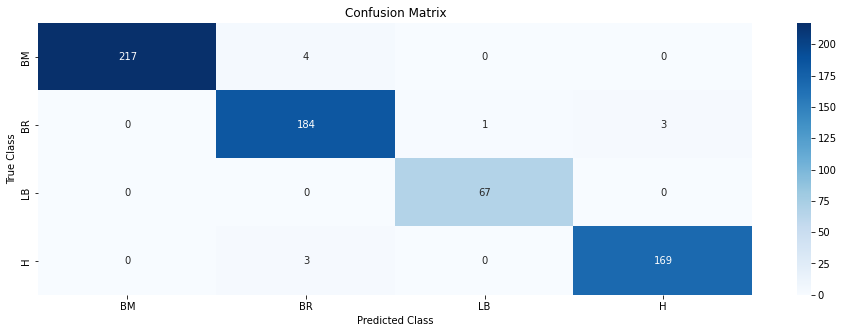

Classification Report
               precision    recall  f1-score   support

black_measles       1.00      0.98      0.99       221
    black_rot       0.96      0.98      0.97       188
  leaf_blight       0.99      1.00      0.99        67
      healthy       0.98      0.98      0.98       172

     accuracy                           0.98       648
    macro avg       0.98      0.99      0.98       648
 weighted avg       0.98      0.98      0.98       648



In [ ]:
# Load the saved model
model = load_model(filepath=os.path.join(model_dir, 'disease-scratch.h5'))

# Get confusion matrix and classification report
get_metrics(model, generator=val_test_gen, steps=total_val)

# **Transfer Learning**

Biasanya praktik terbaik untuk menggunakan kembali model pra-pelatihan yang dilatih pada kumpulan data yang lebih besar, terutama ketika berhadapan dengan kumpulan data terbatas. Basis konvolusi model pra-terlatih ini dapat digunakan kembali dan disesuaikan untuk mencapai kinerja yang lebih baik. Biasanya ini berfungsi dengan baik jika model yang telah dilatih sebelumnya dilatih pada kumpulan data dengan gambar yang mirip dengan kumpulan data baru. Lapisan awal dalam basis konvolusi telah mempelajari fitur tingkat rendah yang berguna yang biasanya digeneralisasi dengan baik sebagai ekstraktor fitur. Namun, lapisan atas biasanya lebih spesifik untuk kelas dan tingkat tinggi dan mungkin tidak berguna untuk kumpulan data yang berbeda. Dalam hal ini, beberapa penyesuaian dapat dilakukan setelah model dilatih pada dataset baru. Lapisan yang lebih tinggi dari dasar konvolusi dapat dicairkan dan dilatih kembali setelah lapisan yang terhubung penuh dilatih. Anda biasanya tidak ingin mencairkan lapisan atas basis konvolusi dengan lapisan pengklasifikasi terhubung penuh yang diinisialisasi secara acak karena kesalahan yang menyebar pada dasarnya akan menghancurkan semua informasi fitur penting yang dipelajari di basis konvolusi. Juga, tingkat pembelajaran untuk lapisan yang disetel dengan baik harus jauh lebih rendah sehingga kita tidak terlalu banyak mendistorsi bobot, karena bobot untuk lapisan tersebut dianggap sudah cukup bagus.

Selain transfer learning, model ini akan menggabungkan augmentasi data dan dropout sebagai sarana regularisasi dan sarana untuk mengurangi overfitting. Selain itu, augmentasi data pada dasarnya akan memungkinkan model kami menjadi lebih kuat untuk sedikit variasi dalam gambar dan pada dasarnya memiliki lebih banyak data pelatihan yang disintesis.

Beberapa model pra-latihan di ImageNet yang ditawarkan Keras dapat ditemukan di modul keras.applications. Aplikasi Keras adalah model pembelajaran mendalam yang tersedia bersama dengan bobot yang telah dilatih sebelumnya. Model-model ini dapat digunakan untuk prediksi, ekstraksi fitur, dan fine-tuning.

https://keras.io/applications/

* Xception
* VGG16
* VGG19
* ResNet, ResNetV2, ResNeXt
* AwalV3
* InceptionResNetV2
* MobileNet
* MobileNetV2
* Jaringan Padat
* NASNet

Bobot diunduh secara otomatis saat membuat model. Mereka disimpan di ~/.keras/models/.

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(img_height, img_width, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 23,104,580
Trainable params: 23,104,580
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Freeze convolutional base
print('Trainable weights before freezing:', len(model.trainable_weights))
conv_base.trainable = False
print('Trainable weights after freezing:', len(model.trainable_weights))

Trainable weights before freezing: 30
Trainable weights after freezing: 4


In [ ]:
# Training data generator with data augmentation
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=40,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

# No data augmentation for validation data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(img_height, img_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=42)

validation_generator = test_datagen.flow_from_directory(
                          validation_dir,
                          target_size=(img_height, img_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

Found 2603 images belonging to 4 classes.
Found 648 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=total_train//batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=total_val//batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
130/130 [==============================] - 54s 392ms/step - loss: 1.1562 - acc: 0.7274 - val_loss: 0.2596 - val_acc: 0.9187
Epoch 2/30
130/130 [==============================] - 50s 384ms/step - loss: 0.3703 - acc: 0.8564 - val_loss: 0.2116 - val_acc: 0.9234
Epoch 3/30
130/130 [==============================] - 51s 392ms/step - loss: 0.3720 - acc: 0.8486 - val_loss: 0.2013 - val_acc: 0.9359
Epoch 4/30
130/130 [==============================] - 50s 387ms/step - loss: 0.3257 - acc: 0.8660 - val_loss: 0.2384 - val_acc: 0.9125
Epoch 5/30
130/130 [==============================] - 50s 382ms/step - loss: 0.3451 - acc: 0.8579 - val_loss: 0.1951 - val_acc: 0.9250
Epoch 6/30
130/130 [==============================] - 50s 382ms/step - loss: 0.3043 - acc: 0.8715 - val_loss: 0.1959 - val_acc: 0.9312
Epoch 7/30
130/130 [==============================] - 51s 390ms/step - loss: 0.3244 - acc: 0.8537 - val_loss: 0.1291 - val_acc: 0.9516
Epoch 8/30
130/130 [==============================] - 5

In [ ]:
model.save(os.path.join(model_dir, 'disease-tl.h5'))

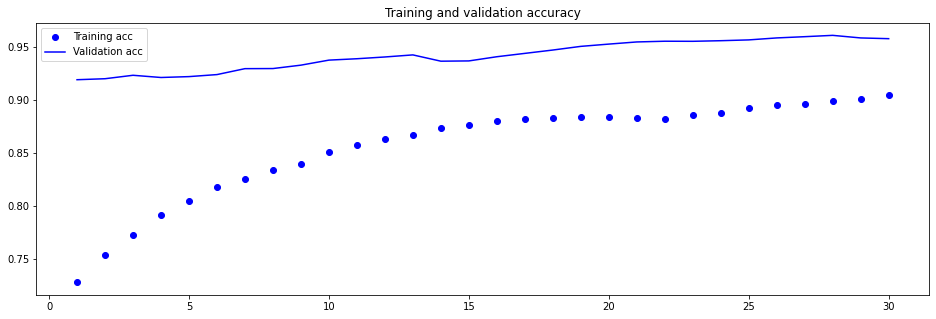

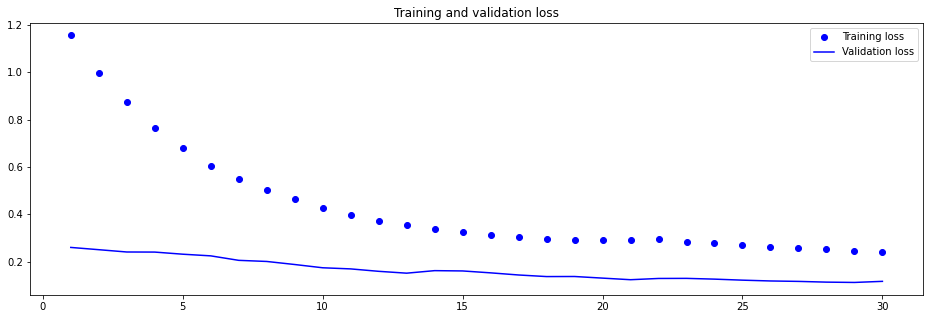

In [ ]:
get_plots(history, smooth=True)

In [ ]:
# Create the new validation generator for test/evaluation
val_test_gen = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 648 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


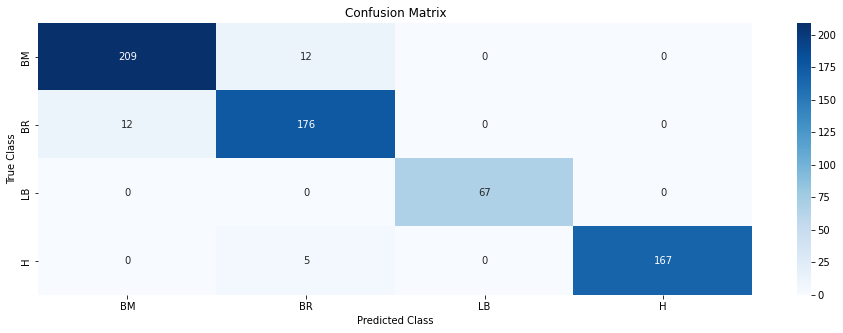

Classification Report
               precision    recall  f1-score   support

black_measles       0.95      0.95      0.95       221
    black_rot       0.91      0.94      0.92       188
  leaf_blight       1.00      1.00      1.00        67
      healthy       1.00      0.97      0.99       172

     accuracy                           0.96       648
    macro avg       0.96      0.96      0.96       648
 weighted avg       0.96      0.96      0.96       648



In [ ]:
# Load the saved model
model = load_model(filepath=os.path.join(model_dir, 'disease-tl.h5'))

# Get confusion matrix and classification report
get_metrics(model, generator=val_test_gen, steps=total_val)

# **Fine-Tune Model**

Setelah melatih lapisan atas yang terhubung sepenuhnya pada dataset kami, kami dapat mencairkan lapisan atas dari basis konvolusi dan menyempurnakan model. Langkah ini hanya boleh dilakukan setelah melatih lapisan yang terhubung penuh pada dataset kami terlebih dahulu. Ini agar kesalahan yang merambat kembali ke basis konvolusi tidak terlalu besar yang menghancurkan representasi yang sudah dipelajari di lapisan atas. Selain itu, tingkat pembelajaran yang lebih kecil harus digunakan untuk membuat perubahan yang lebih kecil dan lebih konservatif pada pembaruan bobot.

In [ ]:
conv_base.layers

In [ ]:
conv_base.layers[0].name

'input_1'

In [ ]:
# Fine-tune convolutional block 5

conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
# Compile the model and use a smaller learning rate for optimizer
model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=total_val // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
130/130 [==============================] - 51s 385ms/step - loss: 0.2273 - acc: 0.9141 - val_loss: 0.0993 - val_acc: 0.9641
Epoch 2/30
130/130 [==============================] - 51s 390ms/step - loss: 0.1893 - acc: 0.9241 - val_loss: 0.0926 - val_acc: 0.9609
Epoch 3/30
130/130 [==============================] - 50s 383ms/step - loss: 0.1923 - acc: 0.9334 - val_loss: 0.0908 - val_acc: 0.9609
Epoch 4/30
130/130 [==============================] - 50s 382ms/step - loss: 0.1864 - acc: 0.9295 - val_loss: 0.0857 - val_acc: 0.9656
Epoch 5/30
130/130 [==============================] - 51s 393ms/step - loss: 0.1753 - acc: 0.9276 - val_loss: 0.0863 - val_acc: 0.9703
Epoch 6/30
130/130 [==============================] - 50s 383ms/step - loss: 0.1808 - acc: 0.9311 - val_loss: 0.0896 - val_acc: 0.9641
Epoch 7/30
130/130 [==============================] - 51s 392ms/step - loss: 0.1660 - acc: 0.9423 - val_loss: 0.0882 - val_acc: 0.9672
Epoch 8/30
130/130 [==============================] - 5

In [ ]:
model.save(os.path.join(model_dir, 'disease-tl-ft.h5'))

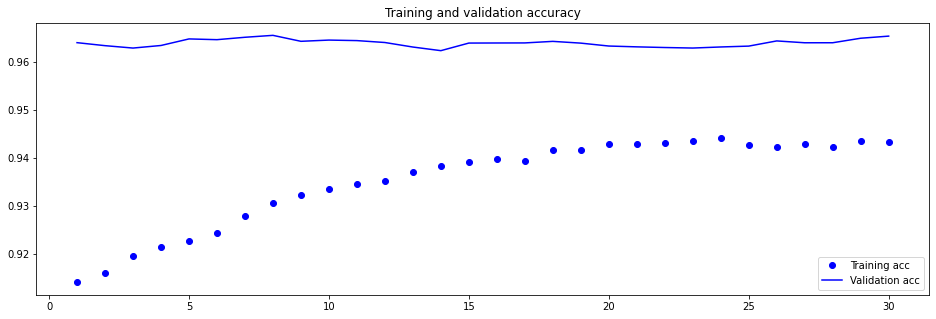

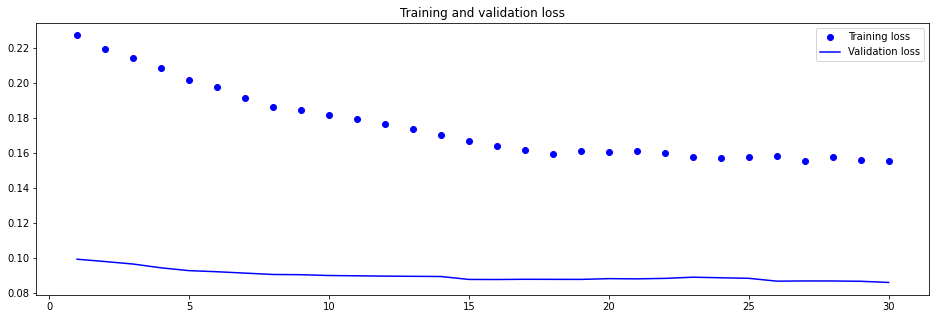

In [ ]:
get_plots(history, smooth=True)

In [ ]:
# Create the new validation generator for test/evaluation
val_test_gen = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 648 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


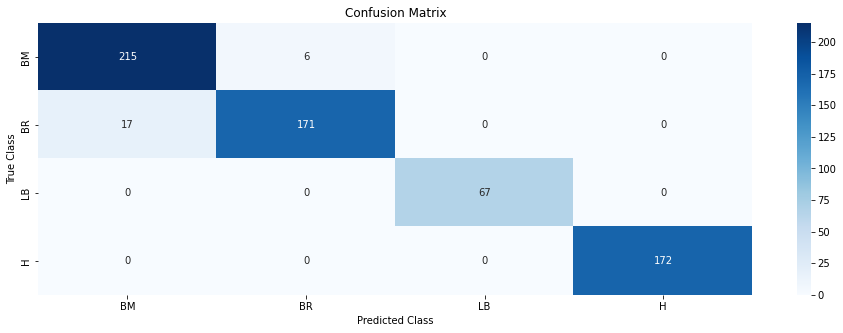

Classification Report
               precision    recall  f1-score   support

black_measles       0.93      0.97      0.95       221
    black_rot       0.97      0.91      0.94       188
  leaf_blight       1.00      1.00      1.00        67
      healthy       1.00      1.00      1.00       172

     accuracy                           0.96       648
    macro avg       0.97      0.97      0.97       648
 weighted avg       0.97      0.96      0.96       648



In [ ]:
# Load the saved model
model = load_model(filepath=os.path.join(model_dir, 'disease-tl-ft.h5'))

# Get confusion matrix and classification report
get_metrics(model, generator=val_test_gen, steps=total_val)

Kami dapat melihat bahwa dengan menerapkan beberapa metode untuk meningkatkan kinerja model kami (yaitu, transfer pembelajaran, augmentasi data, putus sekolah) kami dapat memperoleh akurasi 100%, dan skor F1 antara 0,99-1,00 pada data validasi kami. Namun, mari kita lihat seberapa baik model kita menggeneralisasi ke data yang tidak terlihat, lebih khusus lagi ke kumpulan data pengujian kita yang diadakan.

# **Final Model Evaluation on Test Data**

In [ ]:
# Create the new validation generator for test/evaluation
test_gen = test_datagen.flow_from_directory(
                test_dir,
                target_size=(img_height, img_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 811 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


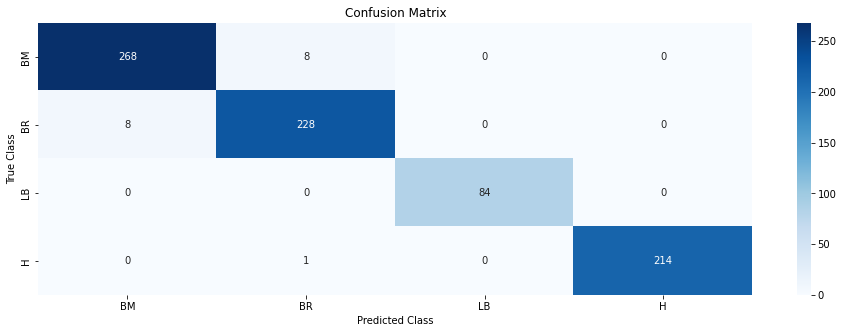

Classification Report
               precision    recall  f1-score   support

black_measles       0.97      0.97      0.97       276
    black_rot       0.96      0.97      0.96       236
  leaf_blight       1.00      1.00      1.00        84
      healthy       1.00      1.00      1.00       215

     accuracy                           0.98       811
    macro avg       0.98      0.98      0.98       811
 weighted avg       0.98      0.98      0.98       811



In [ ]:
# Load the saved model
model = load_model(filepath=os.path.join(model_dir, 'disease-tl-ft.h5'))


# Get confusion matrix and classification report
get_metrics(model, generator=test_gen, steps=total_test)

In [ ]:
# Find the images that were misclassified
y_pred = model.predict_generator(generator=test_gen, steps=total_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Indices where misclassified
idx = np.where(np.not_equal(y_pred, y_true))
idx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


(array([ 22,  24,  73, 115, 136, 146, 166, 204, 285, 378, 394, 398, 408,
        447, 465, 498, 780]),)

Kami melihat bahwa indeks gambar pada 326, 451, dan 502 adalah gambar black_rot yang salah diklasifikasikan sebagai black_measles. Kita dapat menggunakan test_gen.filepaths untuk mendapatkan path ke gambar tersebut dan menemukan path file untuk gambar tertentu.

In [ ]:
filepaths = [test_gen.filepaths[i] for i in idx[0]]
filepaths

['./data/test/black_measles/black_measles1098.jpg',
 './data/test/black_measles/black_measles1101.jpg',
 './data/test/black_measles/black_measles1268.jpg',
 './data/test/black_measles/black_measles216.jpg',
 './data/test/black_measles/black_measles28.jpg',
 './data/test/black_measles/black_measles332.jpg',
 './data/test/black_measles/black_measles434.jpg',
 './data/test/black_measles/black_measles628.jpg',
 './data/test/black_rot/black_rot1046.jpg',
 './data/test/black_rot/black_rot41.jpg',
 './data/test/black_rot/black_rot485.jpg',
 './data/test/black_rot/black_rot494.jpg',
 './data/test/black_rot/black_rot526.jpg',
 './data/test/black_rot/black_rot697.jpg',
 './data/test/black_rot/black_rot774.jpg',
 './data/test/black_rot/black_rot948.jpg',
 './data/test/leaf_blight/leaf_blight832.jpg']

Text(0.5, 1.0, 'black_measles1098.jpg')

Text(0.5, 1.0, 'black_measles1101.jpg')

Text(0.5, 1.0, 'black_measles1268.jpg')

Text(0.5, 1.0, 'black_measles216.jpg')

Text(0.5, 1.0, 'black_measles28.jpg')

Text(0.5, 1.0, 'black_measles332.jpg')

Text(0.5, 1.0, 'black_measles434.jpg')

Text(0.5, 1.0, 'black_measles628.jpg')

Text(0.5, 1.0, 'black_rot1046.jpg')

Text(0.5, 1.0, 'black_rot41.jpg')

Text(0.5, 1.0, 'black_rot485.jpg')

Text(0.5, 1.0, 'black_rot494.jpg')

Text(0.5, 1.0, 'black_rot526.jpg')

Text(0.5, 1.0, 'black_rot697.jpg')

Text(0.5, 1.0, 'black_rot774.jpg')

Text(0.5, 1.0, 'black_rot948.jpg')

Text(0.5, 1.0, 'leaf_blight832.jpg')

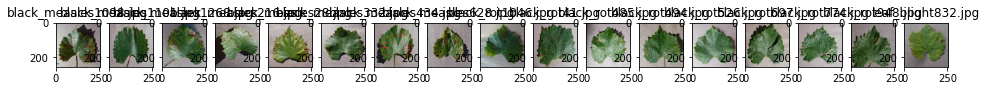

In [ ]:
f = plt.figure()
for i, file in enumerate(filepaths):
  f.add_subplot(1, len(filepaths), i+1)
  img = read_img(filepath=file, size=(256,256))
  plt.title(file.rsplit('/')[-1])
  plt.imshow(img/255.)

Setelah mengamati sampel yang salah klasifikasi ini, kami dapat memahami mengapa model tidak dapat mengklasifikasikannya dengan benar sebagai busuk hitam. Untuk perspektif saya, mereka tampak sangat halus dan bintik-bintik coklat/hitam tidak begitu terlihat dan menyatu dengan sisa daun. Juga tampaknya penyakit ini pada tahap yang relatif awal dan tidak mudah dibedakan.